In [62]:
import pandas as pd
import os
from erddapy import ERDDAP
import numpy as np
import hvplot.pandas
import datashader as ds
import datetime as dt

e = ERDDAP(server="https://dev.cioosatlantic.ca/erddap",
                 protocol="tabledap", )
e.auth = ("cioosatlantic", "4oceans")
e.response = "csv"
e.dataset_id = 'Mar2018_44fa_e1cc_fc53'
e.constraints = { "time<=": "2018-05-23T17:47:30Z", 
                  "time>=": '2018-03-30T20:02:33Z',
                 "Vel_East!=":0,
                 "Vel_North!=":0,
                }
e.variables = ['time','Vel_East','Vel_North','BurstVelocityENU_Range']
df = e.to_pandas()
df['time (UTC)'] = pd.to_datetime(df['time (UTC)'], format="%Y-%m-%dT%H:%M:%SZ")
df

,time (UTC),Vel_East (m/s),Vel_North (m/s),BurstVelocityENU_Range (m)
0,2018-03-30 20:02:33,-1.339414,0.652549,1.5
1,2018-03-30 20:17:30,-1.419244,0.613709,1.5
2,2018-03-30 20:32:30,-1.213854,0.618212,1.5
3,2018-03-30 20:47:30,-1.163068,0.552753,1.5
4,2018-03-30 21:02:30,-1.073227,0.500657,1.5
...,...,...,...,...
165318,2018-05-18 06:32:30,0.636833,-0.690044,38.5
165319,2018-05-18 06:47:30,-0.355382,-0.171419,38.5
165320,2018-05-19 06:47:30,1.950108,-1.191236,38.5
165321,2018-05-19 07:02:30,1.414966,-0.989659,38.5


In [63]:
X = df.iloc[:,1:3].values
X

array([[-1.3394135 ,  0.6525492 ],
       [-1.4192442 ,  0.61370933],
       [-1.2138538 ,  0.6182115 ],
       ...,
       [ 1.9501078 , -1.1912358 ],
       [ 1.4149656 , -0.9896594 ],
       [ 0.8473848 , -0.82836556]])

In [64]:
def standardize_data(arr):
         
    '''
    This function standardize an array, its substracts mean value, 
    and then divide the standard deviation.
    
    param 1: array 
    return: standardized array
    '''    
    rows, columns = arr.shape
    
    standardizedArray = np.zeros(shape=(rows, columns))
    tempArray = np.zeros(rows)
    
    for column in range(columns):
        
        mean = np.mean(X[:,column])
        std = np.std(X[:,column])
        tempArray = np.empty(0)
        
        for element in X[:,column]:
            
            tempArray = np.append(tempArray, ((element - mean) / std))
 
        standardizedArray[:,column] = tempArray
    
    return standardizedArray



In [65]:
X = standardize_data(X)

In [66]:
X

array([[-0.76060441,  0.82772185],
       [-0.79795384,  0.79474626],
       [-0.70186031,  0.79856867],
       ...,
       [ 0.77842431, -0.73767742],
       [ 0.52805377, -0.56653624],
       [ 0.26250658, -0.42959551]])

In [67]:
covariance_matrix = np.cov(X.T)
covariance_matrix

array([[ 1.00000605, -0.99394726],
       [-0.99394726,  1.00000605]])

In [68]:
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print("Eigenvector: \n",eigen_vectors,"\n")
print("Eigenvalues: \n", eigen_values, "\n")

Eigenvector: 
 [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]] 

Eigenvalues: 
 [1.99395331 0.00605879] 



In [69]:
# Calculating the explained variance on each of components

variance_explained = []
for i in eigen_values:
     variance_explained.append((i/sum(eigen_values))*100)
        
print(variance_explained)

[99.69706241258574, 0.302937587414269]


In [70]:
# Identifying components that explain at least 95%

cumulative_variance_explained = np.cumsum(variance_explained)
print(cumulative_variance_explained)

[ 99.69706241 100.        ]


Text(0.5, 1.0, 'Explained variance vs Number of components')

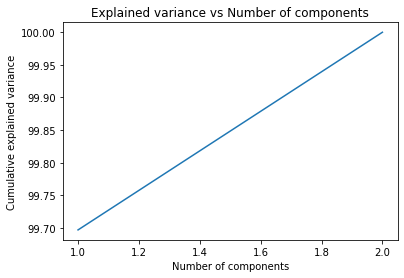

In [71]:
# Visualizing the eigenvalues
%matplotlib inline
import matplotlib.pyplot as plt

x = [1,2]
plt.plot(x,cumulative_variance_explained)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")

In [108]:
# Using the first component (because this explains more than 95%)

projection_matrix = (eigen_vectors.T[:][:1]).T
print(projection_matrix)

[[ 0.70710678]
 [-0.70710678]]


In [109]:
# Getting the product of original standardized X and the eigenvectors 

X_pca = X.dot(projection_matrix)
print(X_pca)
print(X_pca.shape)

[[-1.12311627]
 [-1.12620904]
 [-1.0609635 ]
 ...
 [ 1.07204582]
 [ 0.77399202]
 [ 0.48939008]]
(165323, 1)


In [111]:
df_pca = pd.DataFrame(X_pca, columns = ['Vel_Channel'])
df_pca

,Vel_Channel
0,-1.123116
1,-1.126209
2,-1.060964
3,-1.004865
4,-0.943867
...,...
165318,0.336694
165319,-0.302910
165320,1.072046
165321,0.773992


In [112]:
fulldata = pd.concat([df, df_pca], axis=1)
fulldata

,time (UTC),Vel_East (m/s),Vel_North (m/s),BurstVelocityENU_Range (m),Vel_Channel
0,2018-03-30 20:02:33,-1.339414,0.652549,1.5,-1.123116
1,2018-03-30 20:17:30,-1.419244,0.613709,1.5,-1.126209
2,2018-03-30 20:32:30,-1.213854,0.618212,1.5,-1.060964
3,2018-03-30 20:47:30,-1.163068,0.552753,1.5,-1.004865
4,2018-03-30 21:02:30,-1.073227,0.500657,1.5,-0.943867
...,...,...,...,...,...
165318,2018-05-18 06:32:30,0.636833,-0.690044,38.5,0.336694
165319,2018-05-18 06:47:30,-0.355382,-0.171419,38.5,-0.302910
165320,2018-05-19 06:47:30,1.950108,-1.191236,38.5,1.072046
165321,2018-05-19 07:02:30,1.414966,-0.989659,38.5,0.773992


In [114]:
#adding directions
fulldata['Vel_Mag']=((fulldata['Vel_East (m/s)']**2)+(fulldata['Vel_North (m/s)']**2))**0.5

fulldata

,time (UTC),Vel_East (m/s),Vel_North (m/s),BurstVelocityENU_Range (m),Vel_Channel,Vel_Mag
0,2018-03-30 20:02:33,-1.339414,0.652549,1.5,-1.123116,1.489916
1,2018-03-30 20:17:30,-1.419244,0.613709,1.5,-1.126209,1.546251
2,2018-03-30 20:32:30,-1.213854,0.618212,1.5,-1.060964,1.362214
3,2018-03-30 20:47:30,-1.163068,0.552753,1.5,-1.004865,1.287736
4,2018-03-30 21:02:30,-1.073227,0.500657,1.5,-0.943867,1.184261
...,...,...,...,...,...,...
165318,2018-05-18 06:32:30,0.636833,-0.690044,38.5,0.336694,0.938998
165319,2018-05-18 06:47:30,-0.355382,-0.171419,38.5,-0.302910,0.394564
165320,2018-05-19 06:47:30,1.950108,-1.191236,38.5,1.072046,2.285162
165321,2018-05-19 07:02:30,1.414966,-0.989659,38.5,0.773992,1.726718


In [115]:
import hvplot.pandas
import holoviews.operation.datashader as hd
import datashader as ds

plot = fulldata.hvplot.scatter(x = 'time (UTC)', y=['Vel_East (m/s)', 'Vel_North (m/s)', 'Vel_Channel'
                                                   ,'Vel_Mag']
                               ,datashade=True, subplots=True,width=475,aggregator = 'mean')
spreadplot = hd.dynspread(plot, threshold=.999, max_px=2)
spreadplot.cols(2)

:NdLayout   [Variable]
   :DynamicMap   []
      :RGB   [time (UTC),value]   (R,G,B,A)